# Parameter Estimation Workflow for conversion reaction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import solve_ivp, dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-parameters: k_1, k_2 ~ N(-0.75, 0.25²) iid.
    p_samples = np.random.normal(-0.75, 0.25, size=(batch_size, 2))
    return p_samples.astype(np.float32)


# ODE model for conversion reaction    
def conversion_reaction(t, x, theta):
    theta = 10**theta
    return np.array([-theta[0]*x[0]+theta[1]*x[1], theta[0]*x[0]-theta[1]*x[1]])

x0 = [1,0]   # initial condition       
sigma = 0.015   # noise standard deviation
n_obs = 3
time_points = np.linspace(0, 10, n_obs)
missing_max = 2

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## Computational faithfulness

In [ ]:
# Demo dataset 1 (t=5: 0.4926555573669797)
param_prior = np.array([[-0.7, -0.9]])
result = [np.array([-0.02, 0.499, 0.57]), np.array([1, 2]), np.array([5., 10.])]

In [ ]:
# Demo dataset 1' 
param_prior = np.array([[-0.7, -0.9]])
result = [np.array([-0.02, 0.5, 0.57]), np.array([1, 2]), np.array([5., 10.])]

In [ ]:
# Demo dataset 1'' 
param_prior = np.array([[-0.7, -0.9]])
result = [np.array([-0.02, 0.5, 0.57]), np.array([2]), np.array([10.])]

In [23]:
# Demo dataset 2 (t=10: 0.5023579007634892)
param_prior = np.array([[-0.8 , -0.85]])
result = [np.array([-0.02, 0.42, 0.501]), np.array([0, 2]), np.array([0., 10.])]

In [5]:
# Demo dataset 2'
param_prior = np.array([[-0.8 , -0.85]])
result = [np.array([-0.02, 0.42, 0.5]), np.array([0, 2]), np.array([0., 10.])]

In [39]:
# Demo dataset 2'' 
param_prior = np.array([[-0.8 , -0.85]])
result = [np.array([-0.02, 0.42, 0.52]), np.array([0]), np.array([0.])]

In [24]:
def prior_eval(x,y):   
    # Evaluates prior probability p(theta) according to k_1, k_2 ~ N(-0.75, 0.25²) iid.
    return norm.pdf(x,-0.75,0.25) * norm.pdf(y,-0.75,0.25)

def likelihood(x,y):   
    # Calculates likelihood p(x_{1:N} | theta) by ignoring the missing data
    x = 10**x
    y = 10**y
    s = x + y
    b = x/s
    state_2 = lambda t: b - b * np.exp(-s*t)
    sol = state_2(result[2])
    residual = (result[0][result[1]] - sol)/sigma
    nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
    return np.exp(-nllh)

def unnormalized_posterior(x,y):   
    # Evaluates the unnormalized posterior probability p(theta | x_{1:N}) according to Bayes' formula
    return likelihood(x,y) * prior_eval(x,y)

# scaling factor
scaling_factor = dblquad(unnormalized_posterior, -2.25, 0.75, lambda y: -2.25, lambda y: 0.75)
print(scaling_factor)
# normalized posterior
posterior_xy = lambda x,y: unnormalized_posterior(x,y)/scaling_factor[0]

(21.792739961407094, 4.867704216822422e-07)


TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_augment01(0.5)_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300


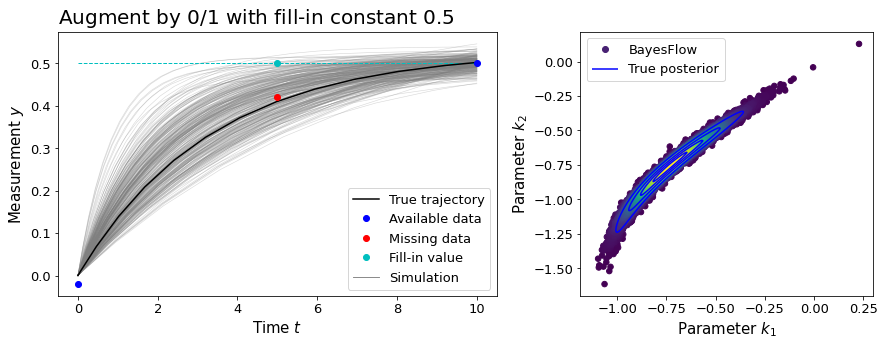

In [26]:
fig, ax = plt.subplots(1, 2, figsize=((12.5, 5)), gridspec_kw={'width_ratios': [3, 2]})
plt.rcParams['font.size'] = 13
n_post_samples = 7500

# Method 1: augment01 (0.5)
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_augment01(0.5)_5ACB_[64,64,64]_LSTM(8)_ckpts', 
                                     skip_checks=True)
sim_data = np.ones((1, n_obs, 2), dtype=np.float32)
sim_data[0, :, 0] = result[0]
missing_indices = np.setdiff1d(range(n_obs), result[1])
sim_data[0][missing_indices] = np.array([0.5, 0.0])
x_data = sim_data
param_samples_1 = amortizer.sample(x_data, n_post_samples) 
mean_sample = np.mean(param_samples_1, axis=0)
cov_sample = np.cov(param_samples_1.transpose())
mean_x = mean_sample[0]
mean_y = mean_sample[1]
std_x = np.sqrt(cov_sample[0, 0])
std_y = np.sqrt(cov_sample[1, 1])

# Level sets of analytic posterior distribution
grid = 201
A = np.linspace(mean_x - 3 * std_x, mean_x + 3 * std_x, grid)
B = np.linspace(mean_y - 3 * std_y, mean_y + 3 * std_y, grid)
true_posterior = np.zeros((grid, grid))
for iy in range(0, grid):
    for ix in range(0, grid):
        true_posterior[iy][ix] = posterior_xy(A[ix], B[iy]) 
        
plot_predictive_2D(ax, param_prior, result, param_samples_1, A, B, true_posterior, 'Augment by $0/1$ with fill-in constant $0.5$')
plt.tight_layout()
plt.show()
#fig.savefig("figures/CR3_augment-insert_2_.png", dpi=600, bbox_inches='tight')  

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_insert0.5_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300


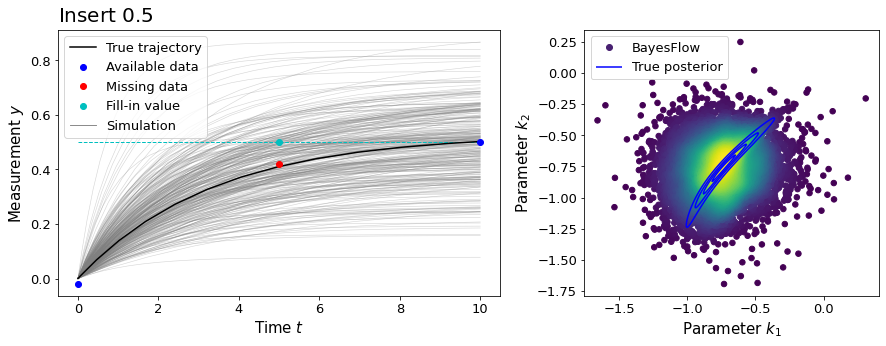

In [38]:
fig, ax = plt.subplots(1, 2, figsize=((12.5, 5)), gridspec_kw={'width_ratios': [3, 2]})
plt.rcParams['font.size'] = 13

# Method 2: insert0.5
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_insert0.5_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)
sim_data = np.ones((1, n_obs, 1), dtype=np.float32)
sim_data[0, :, 0] = result[0]
missing_indices = np.setdiff1d(range(n_obs), result[1])
sim_data[0][missing_indices] = np.array([0.5])
x_data = sim_data
param_samples_2 = amortizer.sample(x_data, n_post_samples)
plot_predictive_2D(ax, param_prior, result, param_samples_2, A, B, true_posterior, 'Insert $0.5$')

plt.tight_layout()
plt.show()
fig.savefig("figures/CR3_augment-insert_2.png", dpi=600, bbox_inches='tight')  

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_augment01(0.5)_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300


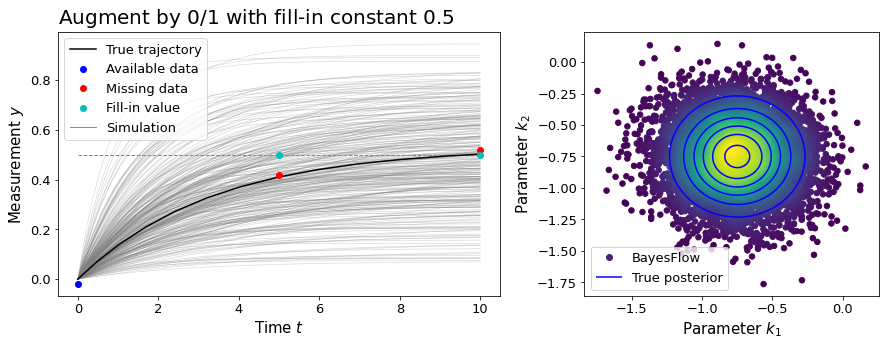

In [41]:
# Make sure that augment01(0.5) is able to detect missing values even if 0.5 is a plausible value for the original data
fig, ax = plt.subplots(1, 2, figsize=((12.5, 5)), gridspec_kw={'width_ratios': [3, 2]})
plt.rcParams['font.size'] = 13
n_post_samples = 7500

# Method 1: augment01 (0.5)
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_augment01(0.5)_5ACB_[64,64,64]_LSTM(8)_ckpts', 
                                     skip_checks=True)
sim_data = np.ones((1, n_obs, 2), dtype=np.float32)
sim_data[0, :, 0] = result[0]
missing_indices = np.setdiff1d(range(n_obs), result[1])
sim_data[0][missing_indices] = np.array([0.5, 0.0])
x_data = sim_data
param_samples_1 = amortizer.sample(x_data, n_post_samples)
mean_sample = np.mean(param_samples_1, axis=0)
cov_sample = np.cov(param_samples_1.transpose())
mean_x = mean_sample[0]
mean_y = mean_sample[1]
std_x = np.sqrt(cov_sample[0, 0])
std_y = np.sqrt(cov_sample[1, 1])

# Level sets of analytic posterior distribution
grid = 201
A = np.linspace(mean_x - 3 * std_x, mean_x + 3 * std_x, grid)
B = np.linspace(mean_y - 3 * std_y, mean_y + 3 * std_y, grid)
true_posterior = np.zeros((grid, grid))
for iy in range(0, grid):
    for ix in range(0, grid):
        true_posterior[iy][ix] = posterior_xy(A[ix], B[iy]) 
        
plot_predictive_2D(ax, param_prior, result, param_samples_1, A, B, true_posterior, 'Augment by $0/1$ with fill-in constant $0.5$')
plt.tight_layout()
plt.show()
fig.savefig("figures/CR3_augment-insert_2__.png", dpi=600, bbox_inches='tight')  

augment01(0.5), insert0.5

KL loss: -4.345, -4.305